In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler, OneHotEncoder,PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)
plt.style.use('seaborn')
%matplotlib inline

In [4]:
train_data = pd.read_csv('./train_data.csv')
test_data = pd.read_csv('./test_features.csv')
data = pd.concat([train_data, test_data], axis = 0)

print(f'train shape: {train_data.shape}')
print(f'test shape: {test_data.shape}')
print(f'total shape: {data.shape}')

data.reset_index(inplace=True, drop=True)
data.head()

train shape: (113, 22)
test shape: (33, 21)
total shape: (146, 22)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


資料分析 [參考](https://bpagare6.github.io/Enron-Fraud-Detection/)

Note: This summary schedule includes payments to either Debtor or non-debtor employees and non-employee directors made on behalf of a Debtor company.

Definitions of Category Groupings:
1. __Salary__: Reflects items such as base salary, executive cash allowances, and benefits payments.反映基本工資、主管現金津貼和福利支付等項目。
2. __Bonus__: Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.反映根據公司績效支付的年度現金獎勵。還可能包括其他保留金（事情做完才拿的到的錢）。
3. __Long Term Incentive__: Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.長期獎勵計劃（包括給予高層管理者、高級專業技術人員的股票、股票期權、紅利和一般員工的勞動分紅、員工持股計劃等形式。目的是用於促使經營者關註企業的長期發展潛力。）
4. __Deferred Income__: Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement.  May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.遞延收入。反映自願執行主管遞延薪資，年度現金獎勵和長期現金獎勵以及非僱員董事根據遞延薪酬安排遞延的現金費用。也可能反映股票期權或虛擬股票單位下的延期，以代替現金安排。
5. __Deferral Payments__: Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.反映根據計劃規定，由於終止僱傭關係或因在職撤職而產生的遞延補償安排的分配。
6. __Loan Advances__: Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment.  In certain instances, the terms of the promissory notes allow for the option to repay with stock of the company.反映債務人為償還承諾而提供的貸款預付款總額,不包括還款。
7. __Other__: Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e. housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.).  May also include payments provided with respect to employment agreements, as well as imputed income amounts for such things as use of corporate aircraft. 反映了諸如嚴重性付款，諮詢服務，搬遷費用，預支稅款和為國際任務分配給僱員的津貼（例如，住房津貼，生活津貼，根據安然稅收均等計劃進行的付款等）等項目。也可能包括與僱傭協議有關的付款，以及使用公務機之類的估算收入金額。
8. __Expense__: Reflects reimbursements of business expenses. May include fees paid for consulting services.反映了業務費用的報銷。可能包括為諮詢服務支付的費用
9. __Director Fees__: Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors. 反映現金支付和/或股票贈款的價值,代替向非雇員董事支付現金。
10. __Exercised Stock Options__:Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and the timing of any subsequent sale of the securities. 買賣認股權？
11. __Restricted Stock__: Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting periods, regardless of whether deferred.僱主承諾給與員工某個固定額度的限制性股票，員工在工作一定時間後，就會轉移到他的戶頭。這種薪資給付方式，稱為限制性股票單位。
12. __Restricted Stock Deferred__: Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement. 
13. __Stock Value__: In 1998, 1999 and 2000, Debtor and non-debtor affiliates were charged for options granted. The Black-Scholes method was used to determine the amount to be charged.  Any amounts charged to Debtor and non-debtor affiliates associated with the options exercised related to these three years have not been subtracted from the share value amounts shown.

In [5]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data, axis):
    data_na = (df_data.isnull().sum(axis = axis) / df_data.shape[axis]) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return missing_data
print(na_check(data, 0))
print()
print(na_check(data, 1)) # 每一筆資料或多或少都有缺值

                           Missing Ratio
loan_advances                  97.260274
director_fees                  88.356164
restricted_stock_deferred      87.671233
deferral_payments              73.287671
deferred_income                66.438356
long_term_incentive            54.794521
bonus                          43.835616
from_messages                  41.095890
from_poi_to_this_person        41.095890
from_this_person_to_poi        41.095890
shared_receipt_with_poi        41.095890
to_messages                    41.095890
other                          36.301370
expenses                       34.931507
salary                         34.931507
exercised_stock_options        30.136986
restricted_stock               24.657534
email_address                  23.972603
poi                            22.602740
total_payments                 14.383562
total_stock_value              13.698630

     Missing Ratio
107      90.909091
65       81.818182
17       81.818182
136      81.818182
79

In [6]:
missing_values = na_check(data, 1)
missing_indexs = missing_values[missing_values['Missing Ratio'] > 80].index # 決定刪掉一些資訊量過少的資料
print(missing_indexs) # 因為 112 之後的是測試資料，不能刪
missing_indexs = missing_indexs.drop(136)
print(missing_indexs)

Int64Index([107, 65, 17, 136, 79, 30], dtype='int64')
Int64Index([107, 65, 17, 79, 30], dtype='int64')


In [7]:
data.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'restricted_stock_deferred', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

In [8]:
payment_columns = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                   'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments']
stock_columns = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
email_columns = ['email_address', 'from_messages', 'to_messages', 'from_poi_to_this_person', 
                 'from_this_person_to_poi', 'shared_receipt_with_poi']
print(f'payment: {len(payment_columns)}, stock: {len(stock_columns)}, email: {len(email_columns)}')

payment: 10, stock: 4, email: 6


In [9]:
df_payment = data[payment_columns]
df_payment = df_payment.fillna(0)
# BELFER, ROBERT 資料有誤
df_payment.at[50, 'deferred_income'] =  -102500
df_payment.at[50, 'deferral_payments'] =  0
df_payment.at[50, 'expenses'] =  3285
df_payment.at[50, 'director_fees'] =  102500

df_payment['bonus_payment_ratio'] = df_payment['bonus'] / df_payment['total_payments']
df_payment['salary_payment_ratio'] = df_payment['salary'] / df_payment['total_payments']
df_payment['bonus_salary_ratio'] = df_payment['bonus'] / df_payment['salary']

df_payment.fillna(0, inplace = True)
df_payment.replace(np.inf, 0, inplace = True)

df_payment['deferred_income'] = abs(df_payment['deferred_income'])

In [10]:
pd.concat([data.name, df_payment], axis = 1)

,name,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,bonus_payment_ratio,salary_payment_ratio,bonus_salary_ratio
0,RICE KENNETH D,420636.0,1750000.0,1617011.0,3504386.0,0.0,0.0,174839.0,46950.0,0.0,505050.0,3.465003,0.832860,4.160367
1,SKILLING JEFFREY K,1111258.0,5600000.0,1920000.0,0.0,0.0,0.0,22122.0,29336.0,0.0,8682716.0,0.644959,0.127985,5.039334
2,SHELBY REX,211844.0,200000.0,0.0,4167.0,0.0,0.0,1573324.0,22884.0,0.0,2003885.0,0.099806,0.105717,0.944091
3,KOPPER MICHAEL J,224305.0,800000.0,602671.0,0.0,0.0,0.0,907502.0,118134.0,0.0,2652612.0,0.301590,0.084560,3.566572
4,CALGER CHRISTOPHER F,240189.0,1250000.0,375304.0,262500.0,0.0,0.0,486.0,35818.0,0.0,1639297.0,0.762522,0.146520,5.204235
5,HIRKO JOSEPH,0.0,0.0,0.0,0.0,10259.0,0.0,2856.0,77978.0,0.0,91093.0,0.000000,0.000000,0.000000
6,YEAGER F SCOTT,158403.0,0.0,0.0,0.0,0.0,0.0,147950.0,53947.0,0.0,360300.0,0.000000,0.439642,0.000000
7,COLWELL WESLEY,288542.0,1200000.0,0.0,144062.0,27610.0,0.0,101740.0,16514.0,0.0,1490344.0,0.805183,0.193608,4.158840
8,LAY KENNETH L,1072321.0,7000000.0,3600000.0,300000.0,202911.0,81525000.0,10359729.0,99832.0,0.0,103559793.0,0.067594,0.010355,6.527896
9,GLISAN JR BEN F,274975.0,600000.0,71023.0,0.0,0.0,0.0,200308.0,125978.0,0.0,1272284.0,0.471593,0.216127,2.182017


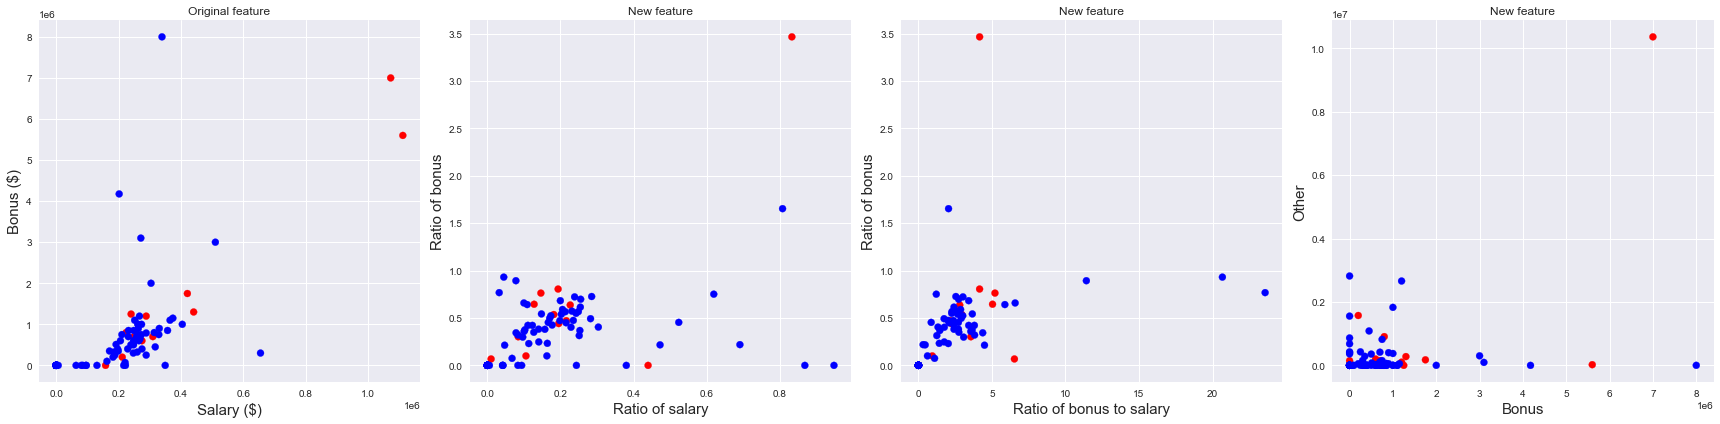

In [11]:
train_num = train_data.shape[0]
color = ['r' if i == True else 'b' for i in train_data.poi]

figure, (axes1, axes2, axes3, axes4) = plt.subplots(ncols = 4, nrows = 1, figsize = (24, 6))
axes1.scatter(df_payment['salary'][:train_num], df_payment['bonus'][:train_num], c = color)
axes1.set_xlabel('Salary ($)', fontsize = 15)
axes1.set_ylabel('Bonus ($)', fontsize = 15)
axes1.set_title('Original feature')

axes2.scatter(df_payment['salary_payment_ratio'][:train_num], df_payment['bonus_payment_ratio'][:train_num], c = color)
axes2.set_xlabel('Ratio of salary', fontsize = 15)
axes2.set_ylabel('Ratio of bonus', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df_payment['bonus_salary_ratio'][:train_num], df_payment['bonus_payment_ratio'][:train_num], c = color)
axes3.set_xlabel('Ratio of bonus to salary', fontsize = 15)
axes3.set_ylabel('Ratio of bonus', fontsize = 15)
axes3.set_title('New feature')

axes4.scatter(df_payment['bonus'][:train_num], df_payment['other'][:train_num], c = color)
axes4.set_xlabel('Bonus', fontsize = 15)
axes4.set_ylabel('Other', fontsize = 15)
axes4.set_title('New feature')

figure.tight_layout()
plt.show()

In [12]:
df_stock = data[stock_columns]
df_stock = df_stock.fillna(0)

# BELFER, ROBERT 資料有誤
df_stock.at[50, 'exercised_stock_options'] =  0
df_stock.at[50, 'restricted_stock'] =  44093
df_stock.at[50, 'restricted_stock_deferred'] =  -44093
df_stock.at[50, 'total_stock_value'] =  0
# BHATNAGAR SANJAY 資料有誤
df_stock.at[139, 'exercised_stock_options'] =  15456290.0
df_stock.at[139, 'restricted_stock'] =  2604490.0
df_stock.at[139, 'restricted_stock_deferred'] =  -2604490.0
df_stock.at[139, 'total_stock_value'] =  15456290.0

# 檢查股價總和
for i in range(len(df_stock)):
    if np.sum(df_stock.iloc[i,:3]) != df_stock['total_stock_value'][i]:
        print(data.name[i])

# 增加特徵
df_stock['exercised_total_ratio'] = df_stock['exercised_stock_options'] / df_stock['total_stock_value']
df_stock['restricted_total_ratio'] = df_stock['restricted_stock'] / df_stock['total_stock_value']
df_stock['exercised_restricted_ratio'] = df_stock['exercised_stock_options'] / df_stock['restricted_stock']
df_stock['restricted_stock_deferred'] = abs(df_stock['restricted_stock_deferred'])
df_stock.replace(np.inf, 0, inplace = True)
df_stock = df_stock.fillna(0)

pd.concat([data.name, df_stock], axis = 1)

,name,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,exercised_total_ratio,restricted_total_ratio,exercised_restricted_ratio
0,RICE KENNETH D,19794175.0,2748364.0,0.0,22542539.0,0.878081,0.121919,7.202166
1,SKILLING JEFFREY K,19250000.0,6843672.0,0.0,26093672.0,0.737727,0.262273,2.812817
2,SHELBY REX,1624396.0,869220.0,0.0,2493616.0,0.651422,0.348578,1.868797
3,KOPPER MICHAEL J,0.0,985032.0,0.0,985032.0,0.000000,1.000000,0.000000
4,CALGER CHRISTOPHER F,0.0,126027.0,0.0,126027.0,0.000000,1.000000,0.000000
5,HIRKO JOSEPH,30766064.0,0.0,0.0,30766064.0,1.000000,0.000000,0.000000
6,YEAGER F SCOTT,8308552.0,3576206.0,0.0,11884758.0,0.699093,0.300907,2.323287
7,COLWELL WESLEY,0.0,698242.0,0.0,698242.0,0.000000,1.000000,0.000000
8,LAY KENNETH L,34348384.0,14761694.0,0.0,49110078.0,0.699416,0.300584,2.326859
9,GLISAN JR BEN F,384728.0,393818.0,0.0,778546.0,0.494162,0.505838,0.976918


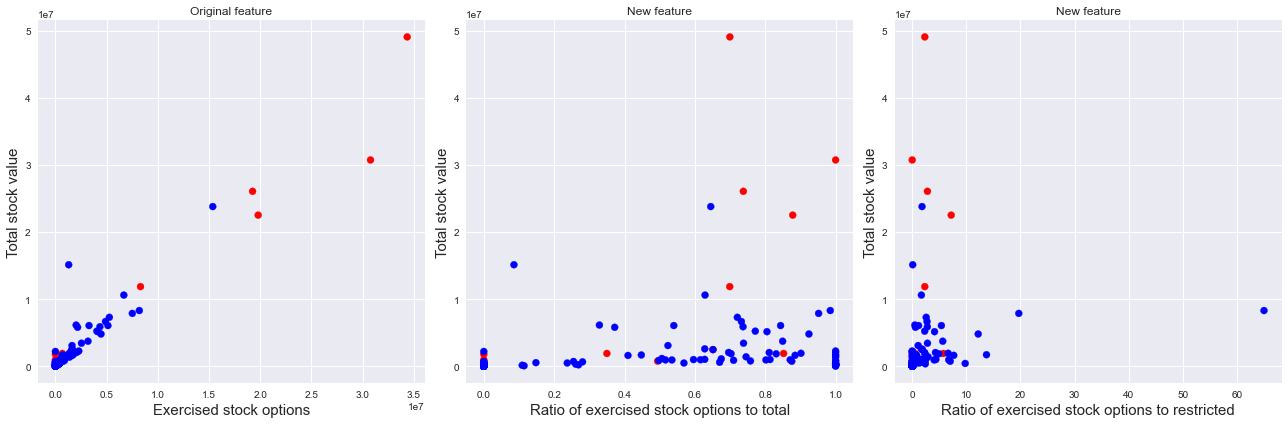

In [13]:
train_num = train_data.shape[0]
color = ['r' if i == True else 'b' for i in train_data.poi]

figure, (axes1, axes2, axes3) = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 6))
axes1.scatter(df_stock['exercised_stock_options'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes1.set_xlabel('Exercised stock options', fontsize = 15)
axes1.set_ylabel('Total stock value', fontsize = 15)
axes1.set_title('Original feature')


axes2.scatter(df_stock['exercised_total_ratio'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes2.set_xlabel('Ratio of exercised stock options to total', fontsize = 15)
axes2.set_ylabel('Total stock value', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df_stock['exercised_restricted_ratio'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes3.set_xlabel('Ratio of exercised stock options to restricted', fontsize = 15)
axes3.set_ylabel('Total stock value', fontsize = 15)
axes3.set_title('New feature')

figure.tight_layout()
plt.show()

In [14]:
df_email = data[email_columns]
df_email = df_email.fillna(0)
df_email['from_poi_ratio'] = df_email['from_poi_to_this_person'] / df_email['to_messages'] # 收信
df_email['to_poi_ratio'] = df_email['from_this_person_to_poi'] / df_email['from_messages'] # 寄信 
df_email['poi_interact_ratio'] = (df_email['from_this_person_to_poi'] + df_email['from_poi_to_this_person']) \
                               / (df_email['from_messages'] + df_email['to_messages'])
df_email['poi_receipt_ratio'] = df_email['shared_receipt_with_poi'] / df_email['to_messages']
df_email = df_email.fillna(0)
df_email.replace(np.inf, 0, inplace = True)

pd.concat([data.name, df_email], axis = 1)

,name,email_address,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio
0,RICE KENNETH D,ken.rice@enron.com,18.0,905.0,42.0,4.0,864.0,0.046409,0.222222,0.049837,0.954696
1,SKILLING JEFFREY K,jeff.skilling@enron.com,108.0,3627.0,88.0,30.0,2042.0,0.024262,0.277778,0.031593,0.563000
2,SHELBY REX,rex.shelby@enron.com,39.0,225.0,13.0,14.0,91.0,0.057778,0.358974,0.102273,0.404444
3,KOPPER MICHAEL J,michael.kopper@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,CALGER CHRISTOPHER F,christopher.calger@enron.com,144.0,2598.0,199.0,25.0,2188.0,0.076597,0.173611,0.081692,0.842186
5,HIRKO JOSEPH,joe.hirko@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,YEAGER F SCOTT,scott.yeager@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,COLWELL WESLEY,wes.colwell@enron.com,40.0,1758.0,240.0,11.0,1132.0,0.136519,0.275000,0.139600,0.643914
8,LAY KENNETH L,kenneth.lay@enron.com,36.0,4273.0,123.0,16.0,2411.0,0.028785,0.444444,0.032258,0.564241
9,GLISAN JR BEN F,ben.glisan@enron.com,16.0,873.0,52.0,6.0,874.0,0.059565,0.375000,0.065242,1.001145


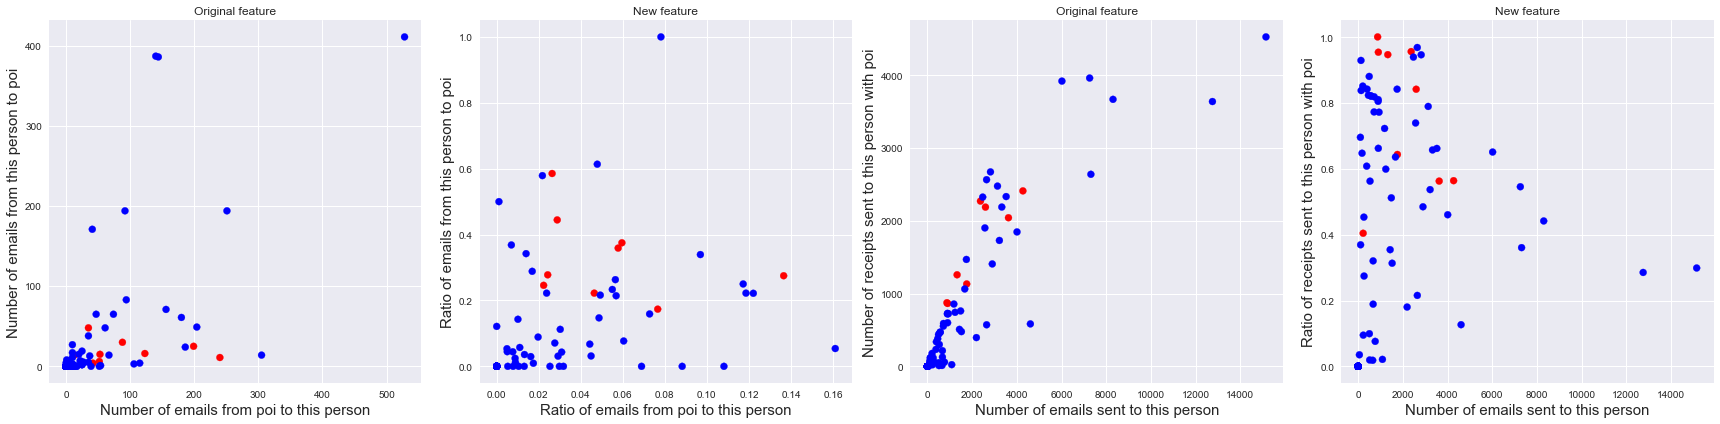

In [15]:
train_num = train_data.shape[0]
color = ['r' if i == True else 'b' for i in train_data.poi]

figure, (axes1, axes2, axes3, axes4) = plt.subplots(ncols = 4, nrows = 1, figsize = (24, 6))
axes1.scatter(df_email['from_poi_to_this_person'][:train_num], df_email['from_this_person_to_poi'][:train_num], c = color)
axes1.set_xlabel('Number of emails from poi to this person', fontsize = 15)
axes1.set_ylabel('Number of emails from this person to poi', fontsize = 15)
axes1.set_title('Original feature')


axes2.scatter(df_email['from_poi_ratio'][:train_num], df_email['to_poi_ratio'][:train_num], c = color)
axes2.set_xlabel('Ratio of emails from poi to this person', fontsize = 15)
axes2.set_ylabel('Ratio of emails from this person to poi', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df_email['to_messages'][:train_num], df_email['shared_receipt_with_poi'][:train_num], c = color)
axes3.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes3.set_ylabel('Number of receipts sent to this person with poi', fontsize = 15)
axes3.set_title('Original feature')

axes4.scatter(df_email['to_messages'][:train_num], df_email['poi_receipt_ratio'][:train_num], c = color)
axes4.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes4.set_ylabel('Ratio of receipts sent to this person with poi', fontsize = 15)
axes4.set_title('New feature')

figure.tight_layout()
plt.show()

In [16]:
df = pd.concat([data['name'], data['poi'], df_payment, df_stock, df_email], axis = 1)
df['total_value'] = df['total_payments'] + df['total_stock_value']
df = df.drop('email_address', axis = 1)
df = df.drop('loan_advances' ,axis = 1)
df = df.drop(missing_indexs, axis = 0) # missing value > 80% (include THE TRAVEL AGENCY IN THE PARK)

print(f'shape: {df.shape}') # 
df.reset_index(inplace=True, drop=True)
df # 訓練資料剩下 108 筆 (113 - 5)

shape: (141, 31)


,name,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,...,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio,total_value
0,RICE KENNETH D,True,420636.0,1750000.0,1617011.0,3504386.0,0.0,174839.0,46950.0,0.0,...,18.0,905.0,42.0,4.0,864.0,0.046409,0.222222,0.049837,0.954696,23047589.0
1,SKILLING JEFFREY K,True,1111258.0,5600000.0,1920000.0,0.0,0.0,22122.0,29336.0,0.0,...,108.0,3627.0,88.0,30.0,2042.0,0.024262,0.277778,0.031593,0.563000,34776388.0
2,SHELBY REX,True,211844.0,200000.0,0.0,4167.0,0.0,1573324.0,22884.0,0.0,...,39.0,225.0,13.0,14.0,91.0,0.057778,0.358974,0.102273,0.404444,4497501.0
3,KOPPER MICHAEL J,True,224305.0,800000.0,602671.0,0.0,0.0,907502.0,118134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3637644.0
4,CALGER CHRISTOPHER F,True,240189.0,1250000.0,375304.0,262500.0,0.0,486.0,35818.0,0.0,...,144.0,2598.0,199.0,25.0,2188.0,0.076597,0.173611,0.081692,0.842186,1765324.0
5,HIRKO JOSEPH,True,0.0,0.0,0.0,0.0,10259.0,2856.0,77978.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,30857157.0
6,YEAGER F SCOTT,True,158403.0,0.0,0.0,0.0,0.0,147950.0,53947.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,12245058.0
7,COLWELL WESLEY,True,288542.0,1200000.0,0.0,144062.0,27610.0,101740.0,16514.0,0.0,...,40.0,1758.0,240.0,11.0,1132.0,0.136519,0.275000,0.139600,0.643914,2188586.0
8,LAY KENNETH L,True,1072321.0,7000000.0,3600000.0,300000.0,202911.0,10359729.0,99832.0,0.0,...,36.0,4273.0,123.0,16.0,2411.0,0.028785,0.444444,0.032258,0.564241,152669871.0
9,GLISAN JR BEN F,True,274975.0,600000.0,71023.0,0.0,0.0,200308.0,125978.0,0.0,...,16.0,873.0,52.0,6.0,874.0,0.059565,0.375000,0.065242,1.001145,2050830.0


In [17]:
# 將訓練、測試資料分開，避免誤刪
df_train = df[:108]
df_test = df[108:]

# 找離群值
outliers = dict()
for feature in df_train.columns:
    if df_train[feature].dtypes == 'float':
        # 統計數續還是用全部的資料
        q25 = df[feature].quantile(0.25)
        q50 = df[feature].quantile(0.5)
        q75 = df[feature].quantile(0.75)
        IQR = q75 - q25
        for i in range(108):
            if df_train[feature][i] > q50 + 1.5 * IQR or df_train[feature][i] < q50 - 1.5 * IQR:
                if df_train['name'][i] not in outliers:
                    outliers[df_train['name'][i]] = 1
                else:
                    outliers[df_train['name'][i]] += 1
                    
df_outliers = pd.DataFrame(outliers.keys(), outliers.values()).reset_index().sort_values(by = 'index', ascending = False)
df_outliers.columns = ['number', 'name']
df_outliers['poi'] = [1 if df_outliers['name'].values[i] in df_train['name'].values[:13] else 0 for i in range(len(df_outliers))]
df_outliers

,number,name,poi
1,16,LAY KENNETH L,1
6,14,LAVORATO JOHN J,0
7,14,WHALLEY LAWRENCE G,0
0,13,SKILLING JEFFREY K,1
3,10,RICE KENNETH D,1
19,10,HAEDICKE MARK E,0
4,9,ALLEN PHILLIP K,0
17,9,BAXTER JOHN C,0
71,9,REDMOND BRIAN L,0
18,9,BUY RICHARD B,0


In [18]:
print(df_train.shape)
for i in range(6):
    drop_index = np.where(df_train['name'].values == df_outliers['name'].values[i])[0]
    df_train.drop(drop_index, inplace = True)
print(df_train.shape)

# KAMINSKI WINCENTY J
# 這個人寄出的信件數量異常的多，可能是秘書或者需要常寄信的職位。而且他的名字寫錯了，是 Vincenty。
# 為了避免信件特徵受到干擾，選擇將其刪除
df_train.drop(df_train[df_train['from_messages'] > df['from_messages'].quantile(0.9)].index, axis = 0, inplace = True)
print(df_train.shape)

# KEAN STEVEN J, SHAPIRO RICHARD S 兩位則是收信異常的多，當作離群值刪除
df_train.drop(df_train[df_train['to_messages'] > df['to_messages'].quantile(0.9)].index, axis = 0, inplace = True)
print(df_train.shape)

# 重新把資料拼起來
df = pd.concat([df_train, df_test], axis = 0)
df.reset_index(inplace = True, drop = True)
print(df.shape)
df # 訓練資料剩下 89 筆 (108 - 6 - 12 - 1)

(108, 31)
(102, 31)
(90, 31)
(89, 31)
(122, 31)


,name,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,...,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio,total_value
0,SHELBY REX,True,211844.0,200000.0,0.0,4167.0,0.0,1573324.0,22884.0,0.0,...,39.0,225.0,13.0,14.0,91.0,0.057778,0.358974,0.102273,0.404444,4497501.0
1,KOPPER MICHAEL J,True,224305.0,800000.0,602671.0,0.0,0.0,907502.0,118134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3637644.0
2,CALGER CHRISTOPHER F,True,240189.0,1250000.0,375304.0,262500.0,0.0,486.0,35818.0,0.0,...,144.0,2598.0,199.0,25.0,2188.0,0.076597,0.173611,0.081692,0.842186,1765324.0
3,HIRKO JOSEPH,True,0.0,0.0,0.0,0.0,10259.0,2856.0,77978.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,30857157.0
4,YEAGER F SCOTT,True,158403.0,0.0,0.0,0.0,0.0,147950.0,53947.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,12245058.0
5,COLWELL WESLEY,True,288542.0,1200000.0,0.0,144062.0,27610.0,101740.0,16514.0,0.0,...,40.0,1758.0,240.0,11.0,1132.0,0.136519,0.275000,0.139600,0.643914,2188586.0
6,GLISAN JR BEN F,True,274975.0,600000.0,71023.0,0.0,0.0,200308.0,125978.0,0.0,...,16.0,873.0,52.0,6.0,874.0,0.059565,0.375000,0.065242,1.001145,2050830.0
7,KOENIG MARK E,True,309946.0,700000.0,300000.0,0.0,0.0,150458.0,127017.0,0.0,...,61.0,2374.0,53.0,15.0,2271.0,0.022325,0.245902,0.027926,0.956613,3507476.0
8,RIEKER PAULA H,True,249201.0,700000.0,0.0,100000.0,214678.0,1950.0,33271.0,0.0,...,82.0,1328.0,35.0,48.0,1258.0,0.026355,0.585366,0.058865,0.947289,3017987.0
9,FASTOW ANDREW S,True,440698.0,1300000.0,1736055.0,1386055.0,0.0,277464.0,55921.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4218495.0


In [19]:
numeric_features = df.dtypes[df.dtypes != "object"].index
skew_of_features = df[numeric_features].apply(lambda x: skew(x, nan_policy = 'omit')).sort_values(ascending=False)
print(skew_of_features)

salary                        10.831801
bonus                         10.797464
total_payments                10.793346
total_value                   10.787301
expenses                      10.764420
total_stock_value             10.699783
exercised_stock_options       10.621511
restricted_stock              10.614706
long_term_incentive           10.593621
deferred_income               10.296246
other                         10.259720
from_this_person_to_poi       10.004438
deferral_payments              9.948052
director_fees                  9.879443
restricted_stock_deferred      8.833018
from_messages                  8.252058
exercised_restricted_ratio     7.497944
bonus_payment_ratio            6.506163
bonus_salary_ratio             4.737542
from_poi_to_this_person        3.072967
to_messages                    2.903741
restricted_total_ratio         2.614082
shared_receipt_with_poi        2.570952
from_poi_ratio                 2.399318
salary_payment_ratio           2.106188


In [20]:
high_skewness = skew_of_features[abs(skew_of_features.values) > 0.9]
skewed_features = high_skewness.index
print(skewed_features)

Index(['salary', 'bonus', 'total_payments', 'total_value', 'expenses',
       'total_stock_value', 'exercised_stock_options', 'restricted_stock',
       'long_term_incentive', 'deferred_income', 'other',
       'from_this_person_to_poi', 'deferral_payments', 'director_fees',
       'restricted_stock_deferred', 'from_messages',
       'exercised_restricted_ratio', 'bonus_payment_ratio',
       'bonus_salary_ratio', 'from_poi_to_this_person', 'to_messages',
       'restricted_total_ratio', 'shared_receipt_with_poi', 'from_poi_ratio',
       'salary_payment_ratio', 'poi_interact_ratio', 'to_poi_ratio'],
      dtype='object')


In [21]:
for feature in skewed_features:
    df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature] + 1))

In [22]:
print(df.shape)
df # 去偏態後的資料

(122, 31)


,name,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,...,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio,total_value
0,SHELBY REX,True,55.960529,51.741420,0.000000,14.015929,0.000000,23.939504,31.258028,0.000000,...,4.177785,18.275543,3.112709,2.214865,8.895412,0.028243,0.185239,0.039100,0.404444,53.609568
1,KOPPER MICHAEL J,True,56.681494,69.718319,60.548669,0.000000,0.000000,22.530243,45.008820,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.836257
2,CALGER CHRISTOPHER F,True,57.555775,76.639852,54.893120,27.930269,0.000000,7.673563,34.585086,0.000000,...,5.893491,50.740155,7.444372,2.562617,26.078296,0.031111,0.121499,0.036543,0.842186,46.173397
3,HIRKO JOSEPH,True,0.000000,0.000000,0.000000,0.000000,16.805053,10.521123,41.101784,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.349758
4,YEAGER F SCOTT,True,52.422269,0.000000,0.000000,0.000000,0.000000,18.237143,37.892115,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.727256
5,COLWELL WESLEY,True,59.961274,75.980966,0.000000,25.480460,19.953884,17.414176,29.012186,0.000000,...,4.209326,43.313042,7.804059,2.065183,21.201442,0.034606,0.161602,0.041635,0.643914,47.797490
6,GLISAN JR BEN F,True,59.320810,65.570731,38.601952,0.000000,0.000000,18.918357,45.642323,0.000000,...,3.116029,32.496676,5.106095,1.681715,19.514036,0.028583,0.189020,0.033481,1.001145,47.301073
7,KOENIG MARK E,True,60.924706,67.763703,52.390802,0.000000,0.000000,18.274575,45.723836,0.000000,...,4.745311,48.925257,5.136450,2.257208,26.380810,0.016451,0.151609,0.020454,0.956613,51.536968
8,RIEKER PAULA H,True,58.031579,67.763703,0.000000,24.070866,27.784324,9.878282,34.017071,0.000000,...,5.132283,38.626508,4.493259,2.928445,21.924823,0.018454,0.224146,0.031958,0.947289,50.318413
9,FASTOW ANDREW S,True,65.875995,77.277940,75.176721,35.683575,0.000000,19.666600,38.195131,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.068791


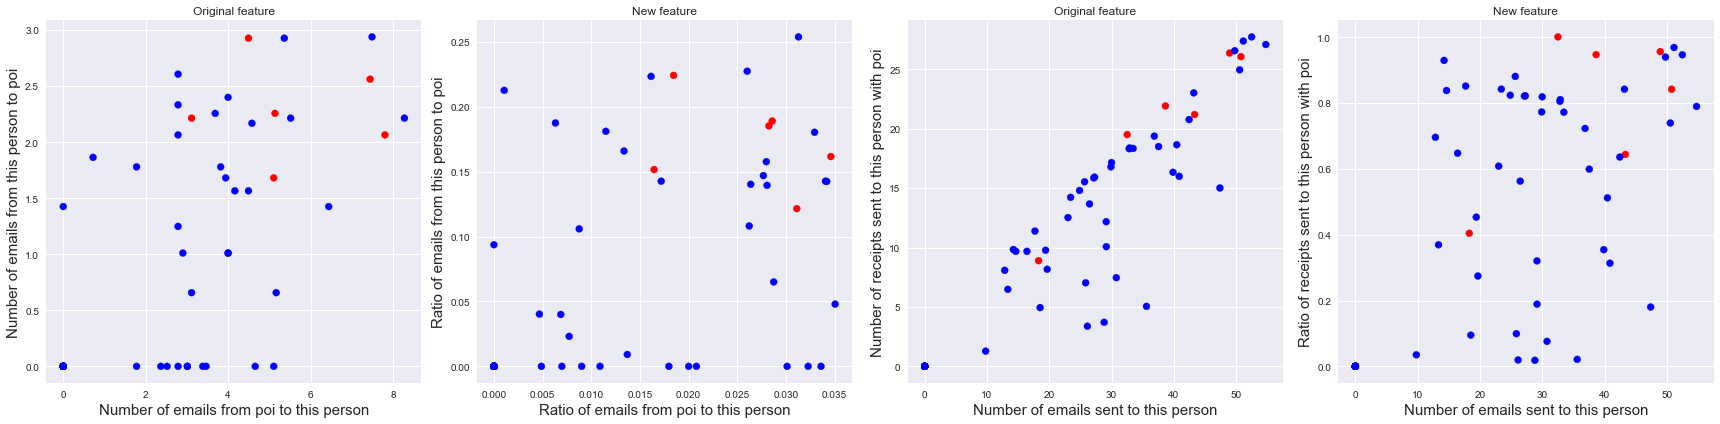

In [23]:
train_num = 89
color = ['r' if i == True else 'b' for i in df[:train_num]['poi']]

figure, (axes1, axes2, axes3, axes4) = plt.subplots(ncols = 4, nrows = 1, figsize = (24, 6))
axes1.scatter(df['from_poi_to_this_person'][:train_num], df['from_this_person_to_poi'][:train_num], c = color)
axes1.set_xlabel('Number of emails from poi to this person', fontsize = 15)
axes1.set_ylabel('Number of emails from this person to poi', fontsize = 15)
axes1.set_title('Original feature')


axes2.scatter(df['from_poi_ratio'][:train_num], df['to_poi_ratio'][:train_num], c = color)
axes2.set_xlabel('Ratio of emails from poi to this person', fontsize = 15)
axes2.set_ylabel('Ratio of emails from this person to poi', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df['to_messages'][:train_num], df['shared_receipt_with_poi'][:train_num], c = color)
axes3.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes3.set_ylabel('Number of receipts sent to this person with poi', fontsize = 15)
axes3.set_title('Original feature')

axes4.scatter(df['to_messages'][:train_num], df['poi_receipt_ratio'][:train_num], c = color)
axes4.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes4.set_ylabel('Ratio of receipts sent to this person with poi', fontsize = 15)
axes4.set_title('New feature')

figure.tight_layout()
plt.show()

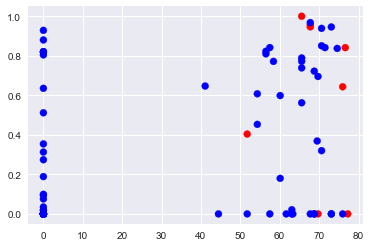

In [24]:
plt.scatter(df['bonus'][:train_num], df['poi_receipt_ratio'][:train_num], c = color)

In [25]:
na_check(df, 0)

,Missing Ratio
poi,27.04918


In [26]:
target = df['poi'][:train_num].astype('int')
df.drop(['name', 'poi'], axis = 1, inplace = True)

mmencoder = MinMaxScaler()
df[:] = mmencoder.fit_transform(df)
df_train = df[:train_num]
df_test = df[train_num:]
print(f'train shape: {df_train.shape}')
print(f'test shape: {df_test.shape}')

train shape: (89, 29)
test shape: (33, 29)


## 開始訓練模型

In [27]:
randomState = 42

In [28]:
def model_selection(x, y, cv):
    # NAIBE BAYES
    nb_model = GaussianNB()
    nb_score = cross_val_score(nb_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Naive Bayes: {nb_score.mean()} \u00B1 {nb_score.std()}')

    #KNN
    knn_model = KNeighborsClassifier()
    knn_score = cross_val_score(knn_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'KNN: {knn_score.mean()} \u00B1 {knn_score.std()}')

    

    #LOGISTIC REGRESSION
    lr_model = LogisticRegression()
    lr_score = cross_val_score(lr_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Logistic Regression: {lr_score.mean()} \u00B1 {lr_score.std()}')

    #SVM
    svc_model = SVC()
    svc_score = cross_val_score(svc_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'SVM: {svc_score.mean()} \u00B1 {svc_score.std()}')

    #DECISON TREE
    dtree_model = DecisionTreeClassifier()
    dtree_score = cross_val_score(dtree_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Decision Tree: {dtree_score.mean()} \u00B1 {dtree_score.std()}')
    
    #RANDOM FOREST
    rfc_model = RandomForestClassifier(n_estimators = 100,random_state = randomState)
    rfc_score = cross_val_score(rfc_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Random Forest: {rfc_score.mean()} \u00B1 {rfc_score.std()}')
    
    #GRADIENT BOOSTING
    gdbt_model = GradientBoostingClassifier(random_state = randomState)
    gdbt_score = cross_val_score(gdbt_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Gradient Boosting: {gdbt_score.mean()} \u00B1 {gdbt_score.std()}')

    #XGBOOST
    xgb = XGBClassifier(random_state = randomState)
    xgb_score = cross_val_score(xgb, x, y, cv = cv, scoring = 'roc_auc')
    print(f'XGBoost: {xgb_score.mean()} \u00B1 {xgb_score.std()}')

In [29]:
x = df_train
y = target
print(f'x shape: {x.shape}')

# model training
model_selection(x, y, 10)

x shape: (89, 29)
Naive Bayes: 0.8232142857142858 ± 0.26310668473267723
KNN: 0.6276785714285714 ± 0.2702880761939991
Logistic Regression: 0.7982142857142858 ± 0.280197861941762
SVM: 0.7178571428571429 ± 0.273721517947996
Decision Tree: 0.60625 ± 0.20738325028796326
Random Forest: 0.7125 ± 0.22395591083961147
Gradient Boosting: 0.71875 ± 0.3000650971039451
XGBoost: 0.6125 ± 0.26487025125521363


In [30]:
# 測試特徵重要性
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = randomState)

gdbt_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
gdbt_model.fit(x_train, y_train)
FI = pd.DataFrame({'feature':x.columns, 'importance':gdbt_model.feature_importances_}).sort_values(by = 'importance', ascending = False)
FI

,feature,importance
6,expenses,0.102954
1,bonus,0.099879
9,bonus_payment_ratio,0.087755
27,poi_receipt_ratio,0.065901
15,total_stock_value,0.062993
21,from_poi_to_this_person,0.055198
12,exercised_stock_options,0.051085
5,other,0.051048
23,shared_receipt_with_poi,0.046373
28,total_value,0.041482


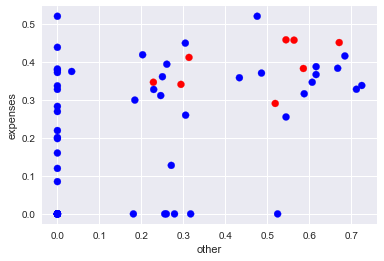

In [31]:
color_ = ['r' if i == 1 else 'b' for i in y_train]
plt.scatter(x_train['other'], x_train['expenses'], c = color_)
plt.xlabel('other')
plt.ylabel('expenses')
plt.show()

shape of x: (89, 1) RF: 0.6946428571428571 ± 0.2486827542168897
shape of x: (89, 2) RF: 0.7482142857142857 ± 0.23127585349137347
shape of x: (89, 3) RF: 0.6107142857142857 ± 0.34418919067802206
shape of x: (89, 4) RF: 0.7357142857142857 ± 0.3089904975092606
shape of x: (89, 5) RF: 0.78125 ± 0.2610824821775678
shape of x: (89, 6) RF: 0.78125 ± 0.2784583676243183
shape of x: (89, 7) RF: 0.76875 ± 0.2767698728185566
shape of x: (89, 8) RF: 0.79375 ± 0.25007811279678194
shape of x: (89, 9) RF: 0.8625 ± 0.1446979612848778
shape of x: (89, 10) RF: 0.775 ± 0.2358495283014151
shape of x: (89, 11) RF: 0.85 ± 0.1920286436967152
shape of x: (89, 12) RF: 0.8375 ± 0.1681703005884214
shape of x: (89, 13) RF: 0.79375 ± 0.17688714622606133
shape of x: (89, 14) RF: 0.7875 ± 0.1920286436967152
shape of x: (89, 15) RF: 0.825 ± 0.21065374432940895
shape of x: (89, 16) RF: 0.7625 ± 0.22150056433336687
shape of x: (89, 17) RF: 0.83125 ± 0.1724139278016715
shape of x: (89, 18) RF: 0.7875 ± 0.2308273164077423

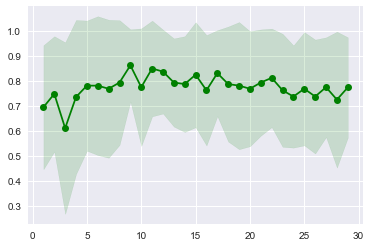

In [32]:
_mean = np.empty(df.shape[1])
_std = np.empty(df.shape[1])
clf = RandomForestClassifier(random_state = randomState)

for i in range(df.shape[1]):
    print(f'shape of x: {x[FI.feature[:i+1]].shape}', end = ' ')
    score = cross_val_score(clf, x[FI.feature[:i+1]], y, cv = 10, scoring = 'roc_auc')
    _mean[i] = score.mean()
    _std[i] = score.std()
    print(f'RF: {score.mean()} \u00B1 {score.std()}')
plt.plot(range(1, df.shape[1] + 1), _mean, color = 'g', marker = 'o')
plt.fill_between(range(1, df.shape[1] + 1), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')
plt.show()

In [33]:
# 特徵篩選後的模型
x = df_train[FI.feature[:9]]
y = target
print(f'shape of x: {x.shape}')

model_selection(x, y, 10)

shape of x: (89, 9)
Naive Bayes: 0.875 ± 0.15811388300841897
KNN: 0.7616071428571429 ± 0.2628111008783646
Logistic Regression: 0.7982142857142858 ± 0.23132410561101213
SVM: 0.8375 ± 0.20953818267800262
Decision Tree: 0.65 ± 0.22569337606584733
Random Forest: 0.8625 ± 0.1446979612848778
Gradient Boosting: 0.75 ± 0.2891258376555094
XGBoost: 0.75 ± 0.24366985862022408


In [34]:
# 選幾個比較強的模型

#RANDOM FOREST
rfc_model = RandomForestClassifier(random_state = 42)
# USING GRID SEARCH
n_estimators = [100, 200, 300, 400]
max_depth = [1, 2, 3]
min_samples_leaf = [1, 2, 3]
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
grid_search_rfc = GridSearchCV(estimator = rfc_model, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
rfc_score = cross_val_score(grid_search_rfc.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('Random Forest Best Parmas',grid_search_rfc.best_params_)
print(f'Random Forest Best Score: {rfc_score.mean()} \u00B1 {rfc_score.std()}')

# GRADIENT BOOSTING
gdbt = GradientBoostingClassifier(random_state = 42)
# USING GRID SEARCH
learning_rate = [0.001, 0.01, 0.1, 1, 10]
n_estimators = [100, 200 ,300]
max_depth = [1, 2, 3, 4, 5]
param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)
grid_search_gdbt = GridSearchCV(estimator = gdbt, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
gdbt_score = cross_val_score(grid_search_gdbt.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('GDBT Best Parmas',grid_search_gdbt.best_params_)
print(f'GDBT Best Score: {gdbt_score.mean()} \u00B1 {gdbt_score.std()}')

Random Forest Best Parmas {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Random Forest Best Score: 0.875 ± 0.15811388300841897
GDBT Best Parmas {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
GDBT Best Score: 0.8125 ± 0.181142209327368


In [35]:
x_test = df_test[FI.feature[:9]]
print(x_test.shape)

(33, 9)


In [36]:
rfc_model = grid_search_rfc.best_estimator_
rfc_model.fit(x, y)
rfc_pred = rfc_model.predict_proba(x_test)[:, 1]
sub = pd.DataFrame({'name':test_data['name'], 'poi':rfc_pred})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_rfc_df_top9_correct.csv', index = False)
sub.head(9)

,name,poi
0,BELDEN TIMOTHY N,0.746195
1,BOWEN JR RAYMOND M,0.510854
2,HANNON KEVIN P,0.826788
3,DELAINEY DAVID W,0.518647
4,CAUSEY RICHARD A,0.238629
5,HICKERSON GARY J,0.680524
6,FREVERT MARK A,0.637883
7,CHAN RONNIE,0.011567
8,DONAHUE JR JEFFREY M,0.373842


### 這個的 random seed 已經跑掉了QQ

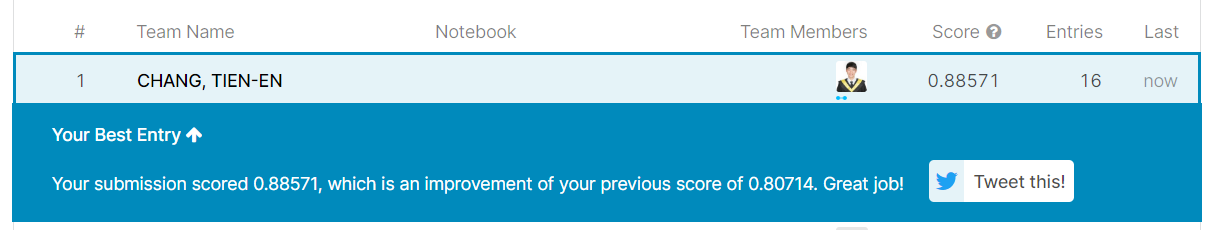

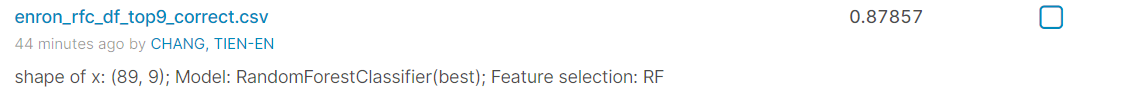

In [37]:
best = [0.613136755, 0.752395568, 0.73414025, 0.608589282, 0.871264836,
        0.580264366, 0.740047975, 0.003482044, 0.662002818, 0.347866289,
        0.131243471, 0.002940538, 0.077062584, 0.003794544, 0.744386669,
        0.013387654, 0.433089611, 0.498173363, 0.200677654, 0.013718085,
        0, 0.706906616, 0.364235246, 0.114540528, 0.164770599,
        0.11948122, 0.348330095, 0.033681945, 0.570771693, 0.4013445,
        0.039556605, 0.489658121, 0.678079163]

In [38]:
gdbt = grid_search_gdbt.best_estimator_
gdbt.fit(x, y)
gdbt_pred = gdbt.predict_proba(x_test)[:, 1]
sub = pd.DataFrame({'name':test_data['name'], 'poi':gdbt_pred})
sub.at[20, 'poi'] = 0 # 更正錯誤值
#sub.to_csv('enron_gdbt_df_correct.csv', index = False)
sub.head(9)

,name,poi
0,BELDEN TIMOTHY N,0.972000
1,BOWEN JR RAYMOND M,0.485705
2,HANNON KEVIN P,0.998286
3,DELAINEY DAVID W,0.630558
4,CAUSEY RICHARD A,0.074614
5,HICKERSON GARY J,0.965994
6,FREVERT MARK A,0.944866
7,CHAN RONNIE,0.012196
8,DONAHUE JR JEFFREY M,0.511251


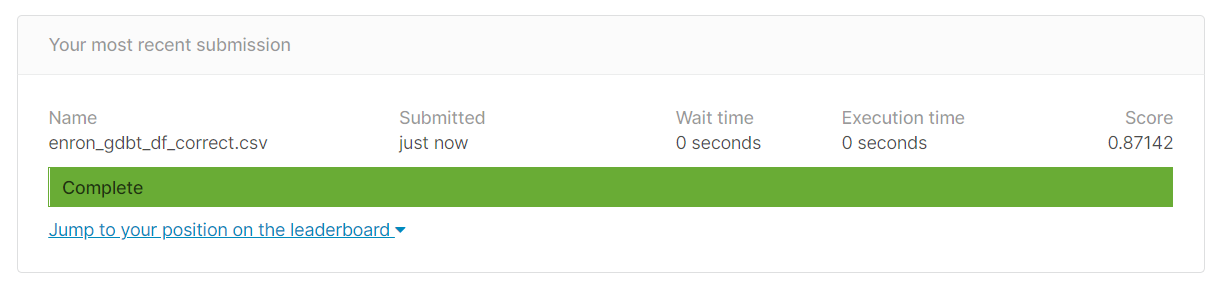

In [39]:
y_blend = 0.6 * gdbt_pred + 0.4 * rfc_pred
sub = pd.DataFrame({'name':test_data['name'], 'poi':y_blend})
sub.at[20, 'poi'] = 0 # 更正錯誤值
#sub.to_csv('enron_gdbt_rf_df_correct_blend.csv', index = False)
sub.head(9)

,name,poi
0,BELDEN TIMOTHY N,0.881678
1,BOWEN JR RAYMOND M,0.495765
2,HANNON KEVIN P,0.929686
3,DELAINEY DAVID W,0.585793
4,CAUSEY RICHARD A,0.140220
5,HICKERSON GARY J,0.851806
6,FREVERT MARK A,0.822073
7,CHAN RONNIE,0.011944
8,DONAHUE JR JEFFREY M,0.456287


Blend 之後結果稍微差了一點，但可能因為原本做 rf 時的 random seed 跑掉了QQ

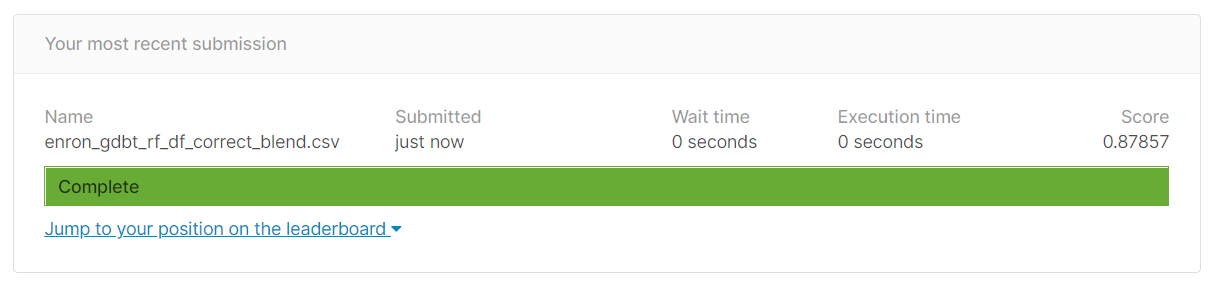

### 葉編碼

In [48]:
onehot = OneHotEncoder()
aa = onehot.fit_transform(rfc_model.apply(x))
aa

<89x1018 sparse matrix of type '<class 'numpy.float64'>'
	with 17800 stored elements in Compressed Sparse Row format>

In [49]:
lr = LogisticRegression()
lr.fit(aa, y)

LogisticRegression()

In [50]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
onehot = OneHotEncoder() # 將訓練過的隨機森林特徵做獨熱編碼
lr = LogisticRegression()
lr.fit(onehot.fit_transform(rfc_model.apply(x)), y) # 再用另一筆訓練資料代入隨機森林模型得到分類別，
                                                 # 以獨熱編碼轉換後，用以訓練邏輯迴歸模型
pred_rf_lr = lr.predict_proba(onehot.transform(rfc_model.apply(x_test)))[:, 1] # 只取生存下來的機率 :1
sub = pd.DataFrame({'name':test_data['name'], 'poi':pred_rf_lr})
sub.at[20, 'poi'] = 0 # 更正錯誤值
#sub.to_csv('enron_gdbt_rf_df_correct_blend.csv', index = False)
sub.head(9)

,name,poi
0,BELDEN TIMOTHY N,0.993856
1,BOWEN JR RAYMOND M,0.773706
2,HANNON KEVIN P,0.998786
3,DELAINEY DAVID W,0.846464
4,CAUSEY RICHARD A,0.060217
5,HICKERSON GARY J,0.979331
6,FREVERT MARK A,0.912936
7,CHAN RONNIE,0.000156
8,DONAHUE JR JEFFREY M,0.112776


In [39]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
onehot = OneHotEncoder()
onehot.fit(rfc_model.apply(x)) # 將訓練過的隨機森林特徵做獨熱編碼
lr = LogisticRegression()
lr.fit(onehot.transform(rfc_model.apply(x)), y) # 再用另一筆訓練資料代入隨機森林模型得到分類別，
                                                 # 以獨熱編碼轉換後，用以訓練邏輯迴歸模型
pred_rf_lr = lr.predict_proba(onehot.transform(rfc_model.apply(x_test)))[:, 1] # 只取生存下來的機率 :1
sub = pd.DataFrame({'name':test_data['name'], 'poi':pred_rf_lr})
sub.at[20, 'poi'] = 0 # 更正錯誤值
#sub.to_csv('enron_gdbt_rf_df_correct_blend.csv', index = False)
sub.head(9)

,name,poi
0,BELDEN TIMOTHY N,0.993856
1,BOWEN JR RAYMOND M,0.773706
2,HANNON KEVIN P,0.998786
3,DELAINEY DAVID W,0.846464
4,CAUSEY RICHARD A,0.060217
5,HICKERSON GARY J,0.979331
6,FREVERT MARK A,0.912936
7,CHAN RONNIE,0.000156
8,DONAHUE JR JEFFREY M,0.112776


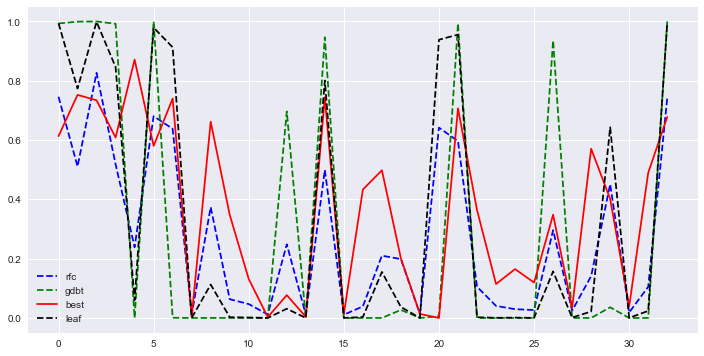

In [40]:
plt.figure(figsize = (12, 6)) # top 9
plt.plot(rfc_pred, 'b--', label = 'rfc')
plt.plot(gdbt_pred, 'g--', label = 'gdbt')
plt.plot(best, 'r', label = 'best')
plt.plot(pred_rf_lr, 'k--', label = 'leaf')
plt.legend()
plt.show()

### 嘗試平衡資料標籤 [參考](https://taweihuang.hpd.io/2018/12/30/imbalanced-data-sampling-techniques/)

In [41]:
# SMOTE
# 透過 SMOTE(Synthetic Minority Oversampling Technique)技術，
# 將不平衡的 POI Label 調整為 True :Fales = 1:1  

sm = SMOTE(random_state = 42)
train_data_res,train_Y_res = sm.fit_resample(df_train, target)
train_data_res = pd.DataFrame(train_data_res, columns = df.columns)

x = train_data_res
y = train_Y_res
print(f'x shape: {x.shape}')

model_selection(x, y, 10)

x shape: (158, 29)
Naive Bayes: 0.8767857142857143 ± 0.07613407045254751
KNN: 0.8690848214285714 ± 0.10323153945090781
Logistic Regression: 0.9066964285714286 ± 0.08113340338854376
SVM: 0.9859375 ± 0.028341183042526648
Decision Tree: 0.9116071428571428 ± 0.07980464828413882
Random Forest: 0.9984375 ± 0.0046875
Gradient Boosting: 0.990625 ± 0.014320549046736998
XGBoost: 0.96875 ± 0.036309218870694535


In [42]:
# 測試特徵重要性
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = randomState)

gdbt_model = RandomForestClassifier(n_estimators = 100, random_state = randomState)
gdbt_model.fit(x_train, y_train)
FI = pd.DataFrame({'feature':x.columns, 'importance':gdbt_model.feature_importances_}).sort_values(by = 'importance', ascending = False)
FI

,feature,importance
6,expenses,0.165480
5,other,0.140271
28,total_value,0.082742
13,restricted_stock,0.054906
10,salary_payment_ratio,0.051090
15,total_stock_value,0.043445
22,from_this_person_to_poi,0.039618
8,total_payments,0.039123
9,bonus_payment_ratio,0.031565
12,exercised_stock_options,0.027184


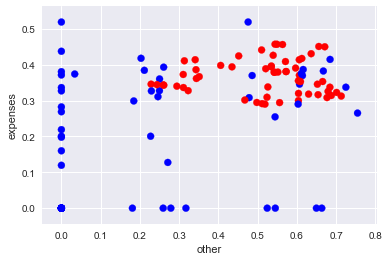

In [43]:
color_ = ['r' if i == 1 else 'b' for i in y_train]
plt.scatter(x_train['other'], x_train['expenses'], c = color_)
plt.xlabel('other')
plt.ylabel('expenses')
plt.show()

shape of x: (158, 1) RF: 0.7814732142857143 ± 0.11294709027191828
shape of x: (158, 2) RF: 0.9100446428571429 ± 0.06076227423348726
shape of x: (158, 3) RF: 0.9407366071428571 ± 0.06849160407380832
shape of x: (158, 4) RF: 0.9487723214285714 ± 0.07039650947820894
shape of x: (158, 5) RF: 0.9633928571428572 ± 0.03790964603837792
shape of x: (158, 6) RF: 0.9665178571428571 ± 0.04414905469670041
shape of x: (158, 7) RF: 0.9755580357142858 ± 0.030890994279610166
shape of x: (158, 8) RF: 0.9716517857142858 ± 0.03401437107184646
shape of x: (158, 9) RF: 0.9732142857142858 ± 0.033482142857142856
shape of x: (158, 10) RF: 0.9786830357142857 ± 0.02564755454948137
shape of x: (158, 11) RF: 0.9828125 ± 0.02633171804117612
shape of x: (158, 12) RF: 0.98828125 ± 0.02014655774723067
shape of x: (158, 13) RF: 0.98984375 ± 0.013997244427475717
shape of x: (158, 14) RF: 0.9890625 ± 0.01530931089239486
shape of x: (158, 15) RF: 0.98671875 ± 0.019779670158081505
shape of x: (158, 16) RF: 0.9953125 ± 0.01

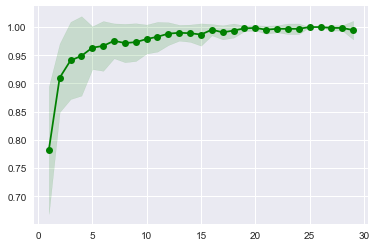

In [44]:
_mean = np.empty(df.shape[1])
_std = np.empty(df.shape[1])
clf = RandomForestClassifier(random_state = randomState)

for i in range(df.shape[1]):
    print(f'shape of x: {x[FI.feature[:i+1]].shape}', end = ' ')
    score = cross_val_score(clf, x[FI.feature[:i+1]], y, cv = 10, scoring = 'roc_auc')
    _mean[i] = score.mean()
    _std[i] = score.std()
    print(f'RF: {score.mean()} \u00B1 {score.std()}')
plt.plot(range(1, df.shape[1] + 1), _mean, color = 'g', marker = 'o')
plt.fill_between(range(1, df.shape[1] + 1), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')
plt.show()

### 目前選前 16 名的特徵有最好的結果

In [45]:
# smote
x = train_data_res[FI.feature[:16]]
y = train_Y_res
print(f'shape of x: {x.shape}')

model_selection(x, y, 10)

shape of x: (158, 16)
Naive Bayes: 0.8986607142857143 ± 0.06018678409411685
KNN: 0.8997767857142855 ± 0.10008715510029959
Logistic Regression: 0.8957589285714287 ± 0.09376620820774488
SVM: 0.9890625 ± 0.027994488854951434
Decision Tree: 0.9053571428571429 ± 0.09349028651934588
Random Forest: 0.9953125 ± 0.010004881620988827
Gradient Boosting: 0.9825892857142857 ± 0.019066211164341627
XGBoost: 0.9671875 ± 0.032362992464387466


In [46]:
# 選幾個比較強的模型

#RANDOM FOREST
rfc_model = RandomForestClassifier(random_state = 42)
# USING GRID SEARCH
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800]
max_depth = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3]
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
grid_search_rfc = GridSearchCV(estimator = rfc_model, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
rfc_score = cross_val_score(grid_search_rfc.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('Random Forest Best Parmas',grid_search_rfc.best_params_)
print(f'Random Forest Best Score: {rfc_score.mean()} \u00B1 {rfc_score.std()}')

# GRADIENT BOOSTING
gdbt = GradientBoostingClassifier(random_state = 42)
# USING GRID SEARCH
learning_rate = [0.001, 0.01, 0.1, 1, 10]
n_estimators = [100, 200 ,300]
max_depth = [1, 2, 3, 4, 5]
param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)
grid_search_gdbt = GridSearchCV(estimator = gdbt, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
gdbt_score = cross_val_score(grid_search_gdbt.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('GDBT Best Parmas',grid_search_gdbt.best_params_)
print(f'GDBT Best Score: {gdbt_score.mean()} \u00B1 {gdbt_score.std()}')

Random Forest Best Parmas {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 300}
Random Forest Best Score: 0.9953125 ± 0.010004881620988827
GDBT Best Parmas {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
GDBT Best Score: 0.9921875 ± 0.014405538214520137


In [47]:
x_test = df_test[FI.feature[:16]]
print(x_test.shape)

(33, 16)


In [48]:
rfc_model = grid_search_rfc.best_estimator_
rfc_model.fit(x, y)
rfc_pred_sm = rfc_model.predict_proba(x_test)[:, 1]
sub = pd.DataFrame({'name':test_data['name'], 'poi':rfc_pred_sm})
sub.at[20, 'poi'] = 0 # 更正錯誤值
#sub.to_csv('enron_rfc_df_top16_smote_correct.csv', index = False)
sub

,name,poi
0,BELDEN TIMOTHY N,0.599474
1,BOWEN JR RAYMOND M,0.734135
2,HANNON KEVIN P,0.746948
3,DELAINEY DAVID W,0.567600
4,CAUSEY RICHARD A,0.907430
5,HICKERSON GARY J,0.525414
6,FREVERT MARK A,0.516263
7,CHAN RONNIE,0.000111
8,DONAHUE JR JEFFREY M,0.590342
9,REYNOLDS LAWRENCE,0.396383


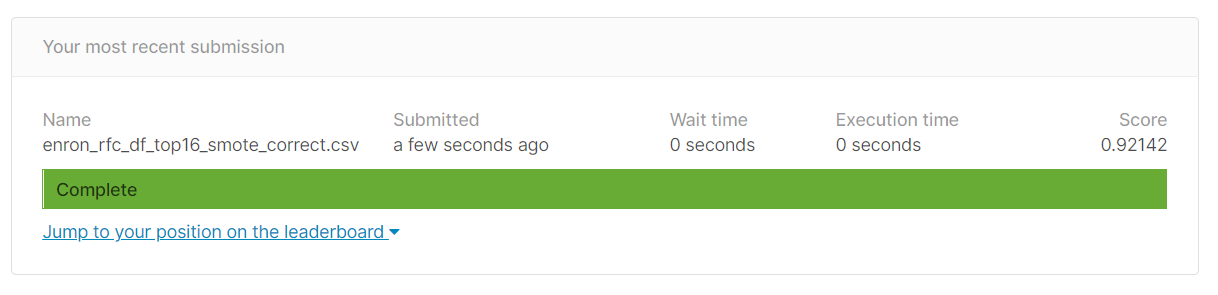

In [49]:
gdbt = grid_search_gdbt.best_estimator_
gdbt.fit(x, y)
gdbt_pred_sm = gdbt.predict_proba(x_test)[:, 1]
sub = pd.DataFrame({'name':test_data['name'], 'poi':gdbt_pred_sm})
sub.at[20, 'poi'] = 0 # 更正錯誤值
#sub.to_csv('enron_gdbt_df_correct.csv', index = False)
sub

,name,poi
0,BELDEN TIMOTHY N,0.998911
1,BOWEN JR RAYMOND M,0.992931
2,HANNON KEVIN P,0.902928
3,DELAINEY DAVID W,0.620024
4,CAUSEY RICHARD A,0.999800
5,HICKERSON GARY J,0.004911
6,FREVERT MARK A,0.980527
7,CHAN RONNIE,0.000152
8,DONAHUE JR JEFFREY M,0.001470
9,REYNOLDS LAWRENCE,0.000237


In [50]:
y_blend_sm = 0.6 * gdbt_pred_sm + 0.4 * rfc_pred_sm
sub = pd.DataFrame({'name':test_data['name'], 'poi':y_blend_sm})
sub.at[20, 'poi'] = 0 # 更正錯誤值
#sub.to_csv('enron_gdbt_rf_df_smote_correct_blend.csv', index = False)
sub.head(9)

,name,poi
0,BELDEN TIMOTHY N,0.839136
1,BOWEN JR RAYMOND M,0.889412
2,HANNON KEVIN P,0.840536
3,DELAINEY DAVID W,0.599054
4,CAUSEY RICHARD A,0.962852
5,HICKERSON GARY J,0.213112
6,FREVERT MARK A,0.794821
7,CHAN RONNIE,0.000136
8,DONAHUE JR JEFFREY M,0.237019


### 葉編碼

In [51]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
onehot = OneHotEncoder()
onehot.fit(rfc_model.apply(x)) # 將訓練過的隨機森林特徵做獨熱編碼
lr = LogisticRegression(random_state = randomState)
lr.fit(onehot.transform(rfc_model.apply(x)), y) # 再用另一筆訓練資料代入隨機森林模型得到分類別，
                                                 # 以獨熱編碼轉換後，用以訓練邏輯迴歸模型
pred_rf_lr_sm = lr.predict_proba(onehot.transform(rfc_model.apply(x_test)))[:, 1] # 只取生存下來的機率 :1
sub = pd.DataFrame({'name':test_data['name'], 'poi':pred_rf_lr_sm})
sub.at[20, 'poi'] = 0 # 更正錯誤值
#sub.to_csv('enron_df_correct_leaf.csv', index = False)
sub

,name,poi
0,BELDEN TIMOTHY N,0.752639
1,BOWEN JR RAYMOND M,0.971893
2,HANNON KEVIN P,0.981910
3,DELAINEY DAVID W,0.364829
4,CAUSEY RICHARD A,0.999688
5,HICKERSON GARY J,0.163706
6,FREVERT MARK A,0.309042
7,CHAN RONNIE,0.000083
8,DONAHUE JR JEFFREY M,0.578129
9,REYNOLDS LAWRENCE,0.057610


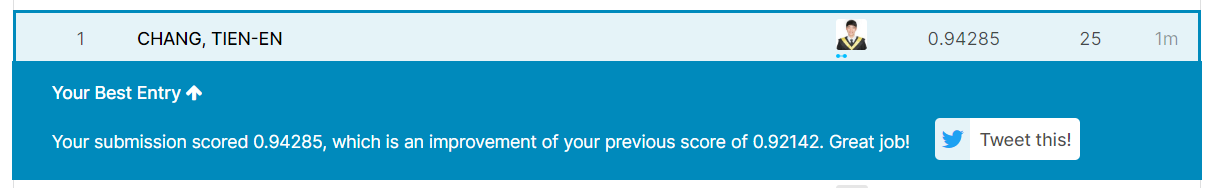

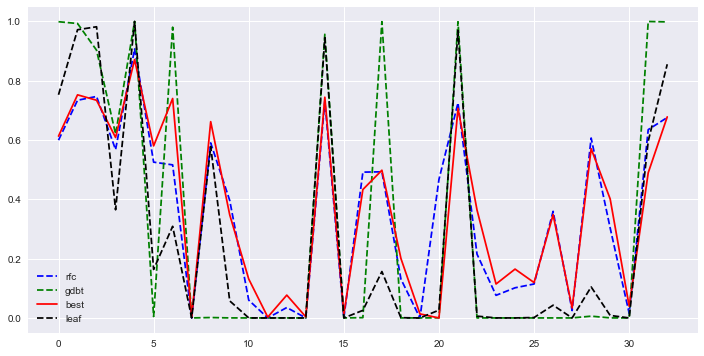

In [52]:
plt.figure(figsize = (12, 6)) # 16
plt.plot(rfc_pred_sm, 'b--', label = 'rfc')
plt.plot(gdbt_pred_sm, 'g--', label = 'gdbt')
plt.plot(best, 'r', label = 'best')
plt.plot(pred_rf_lr_sm, 'k--', label = 'leaf')
plt.legend()
plt.show()